# Simulating GW detector noise (without LAL)

Simulate time-domain strain noise from a given power specral density (PSD). **NOTE:** There might be cleverer ways of doing this, but I this is the most transparent to me.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import scipy.signal as ssig
from tqdm.notebook import tqdm

sns.set(context='notebook', palette='colorblind')

We will simulate detector data containing noise for a number of detectors. To do this, we will download a design PSD for Advanced LIGO. The choices below correspond to the design sensitivities of advanced LIGO Hanford (`H1`), LIGO Livingston (`L1`) and Virgo (`V1`). Since these are projected sensitivies, these are the same for H and L, but in a real analysis that would not be the case (because, although the detectors have the same design, in real life they are independent).

Of course, the this PSD could be replaced with whatever PSD you want.

Download the PSD, if not already on disk; then create an interpolant.

In [4]:
!wget -nc https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt

File ‘aLIGODesign.txt’ already there; not retrieving.



In [18]:
raw_psd_freq, raw_psd = np.loadtxt('aLIGODesign.txt', unpack=True)

# interpolate; this also sets which interferometers we'll simulate
psd_func_dict = {
    'H1': interp1d(raw_psd_freq, raw_psd),
}

## Frequency-domain noise

Next, construct a list of time-stamps for each detector; for simplicity, we can take this to be the same for all IFOs (this is usually be the case in real life). We will construct the time-stamps based on a reference GPS time, which here we choose based on the first LIGO detection (GW150914). 

Constructing the time array here will defined important quantities like `delta_t`. (If you are staying in the Fourier domain, that's basically all you need.)

In [20]:
# detectors we will simulate
ifos = list(psd_func_dict.keys())

# define center of time array
tgps_geo = 1126259462.423

# define sampling rate and duration
fsamp = 4096
duration = 4

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

epoch = tgps_geo - 0.5*tlen*delta_t

time_dict = {i: np.arange(tlen)*delta_t + epoch for i in ifos}

Now we want to instantiate the PSDs, to get an array of values instead of a function. To do this, we need an array of frequencies corresponding to the time series data we constructed above. **NOTE:** all this does is evaluate the PSDs at the desired frequencies---you could skip straight to this part if you had an array in the first place.

In [21]:
freqs = np.fft.rfftfreq(tlen, delta_t)
delta_f = freqs[1] - freqs[0]

# we will want to pad low frequencies; the function below applies a
# prescription to do so smoothly, but this is not really needed: you
# could just set all values below `fmin` to a constant.
fmin = 10
def pad_low_freqs(f, psd_ref):
    return psd_ref + psd_ref*(fmin-f)*np.exp(-(fmin-f))/3

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(freqs))
    for i,f in enumerate(freqs):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = pad_low_freqs(f, psd_func_dict[ifo](fmin))
    psd_dict[ifo] = psd

#### Adding noise to data

If we are not doing a no-noise simulation, then we should add noise to the data; this should match the PSD above. To do this, first simulate noise with the right variance, $S(f)/(4 \Delta f)$, in the Fourier domain and then IFFT back into the time domain. Recall that, since we assume the noise is stationary, the covariance of the noise is diagonal in the Fourier domain.

In [22]:
rng = np.random.default_rng(12345)

noise_fd_dict = {}
for ifo, psd in psd_dict.items():
    var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag

In [23]:
# IFFT into the time domain
noise_td_dict = {}
for ifo, noise_fd in noise_fd_dict.items():
    noise_td_dict[ifo] = np.fft.irfft(noise_fd) / delta_t

As a sanity check, let's manually compute the PSD from the simulated data using Welch and compare to the one we prescribed.

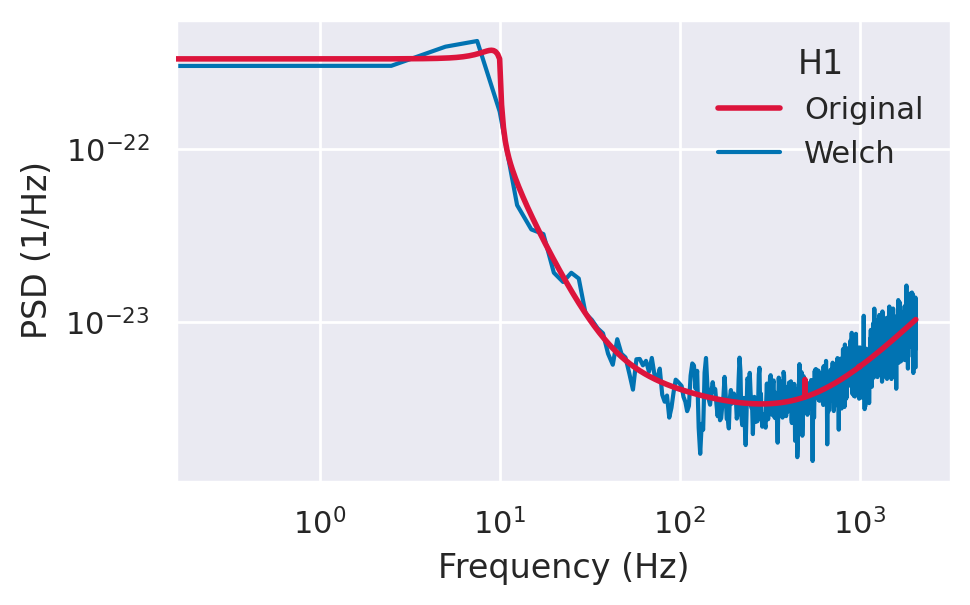

In [25]:
fig, axs = plt.subplots(1, len(ifos), figsize=(5*len(ifos), 3))
axs = np.atleast_1d(axs)
for ax, (ifo, noise) in zip(axs, noise_td_dict.items()):
    # compute Welch PSD
    psd_freq, psd_data = ssig.welch(noise, fs=1./delta_t, nperseg=0.1*duration/delta_t)
    
    ax.loglog(freqs, psd_dict[ifo], label='Original', c='crimson', lw=2, zorder=100)
    ax.loglog(psd_freq, psd_data, label='Welch')
    ax.legend(loc='upper right', frameon=False, title=ifo);
    ax.set_xlabel("Frequency (Hz)");
    # ax.set_ylim(1E-47, 1E-46)
axs[0].set_ylabel(r"PSD ($1/\mathrm{Hz}$)");

We are done! now you can take the time (or frequency) series above and add a signal to it.

## Create segments

We'll repeat the above a number of times to several noise samples.

In [47]:
n_segments = 100
export_path = 'noise_data/noise_{ifo}_{n}.npy'

rng = np.random.default_rng(12345)

export_dir = os.path.dirname(export_path)
os.makedirs(export_dir, exist_ok=True)

for n in tqdm(range(n_segments)):
    for ifo, psd in psd_dict.items():
        var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
        noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
        noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
        noise_fd = noise_real + 1j*noise_imag

        noise_td = np.fft.irfft(noise_fd) / delta_t
        
        time_noise_td = np.vstack([time_dict[ifo], noise_td])
        np.save(export_path.format(ifo=ifo, n=n), time_noise_td)

  0%|          | 0/100 [00:00<?, ?it/s]